In [1]:
import pandas as pd 
import numpy as np 
from datetime import timedelta
import scipy.stats as stats
import matplotlib.pyplot as plt 
from matplotlib.dates import date2num
import matplotlib.dates as mdates
import seaborn as sns 

from matplotlib.colors import Normalize

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


## Reading Data

In [2]:
driver_ids = pd.read_csv('driver_ids.csv')
ride_timestamps = pd.read_csv('ride_timestamps.csv')
ride_ids = pd.read_csv('ride_ids.csv')

### Checking some basics of each dataframe to understand their structure and the kind of data stores

In [3]:
driver_ids.head() 
driver_ids.describe()
driver_ids.isna().sum()
print('Shape of data: ', ride_ids.shape)

Shape of data:  (193502, 5)


In [4]:
ride_timestamps.head()
ride_timestamps.describe()
ride_timestamps.isna().sum()
print('Shape of data: ', ride_timestamps.shape)

Shape of data:  (970405, 3)


In [5]:
ride_ids.head()
ride_ids.describe()
ride_ids.isna().sum() #no nulls
print('Shape of data: ', ride_timestamps.shape)

Shape of data:  (970405, 3)


## Data Prep - Ride Data

In [6]:
ride_ids = ride_ids[ride_ids['ride_distance']>=0]

## Calculate the Total Cost of Ride

**Assumptions about the Lyft rate card(in $$)**

* Base Fare: 2.00
* Cost per Mile: 1.15
* Cost per Minute: 0.22
* Service Fee: 1.75
* Minimum Fare: 5.00
* Maximum Fare: 400.00
* Lyft profit percentage: 20%

I am also applying assumptions regarding applying the Prime Time rate and the Service Fee in line with the actual pricing model of Lyft as described in many articles such as [this one](https://www.ridester.com/lyft-cost/)

So then the total fare will be calculated as:
$(base fare + cost per mile × ride distance + cost per minute × ride duration)× (1+\frac{ride prime time}{100})+service fee $

Based on some of the articles i was able to look through, I found that lyft takes 20 percent of fare exclusive of service charge, as its own profit, so I have also added that as a column. 

Once this is done, I will then cap the values of fare to be atleast equal to minimum fare and at most equal to maximum fare. 

In [7]:
basefare = 2.00
costpermile = 1.15
costpermin = 0.22
service_fee = 1.75
lyft_profit_percentage = 0.20

min_fare = 5.00
max_fare = 400.00

In [8]:
#converting distance from meters to miles and time from seconds to minutes
ride_ids['ride_distance'] = ride_ids['ride_distance']*0.000621
ride_ids['ride_duration'] = ride_ids['ride_duration']/60


In [9]:
ride_ids['basefare'] = basefare + (costpermin*ride_ids['ride_duration']) + (costpermile*ride_ids['ride_distance'])
ride_ids['ride_total_cost'] = (ride_ids['basefare'] * (1 + ride_ids['ride_prime_time']/100) ) + service_fee
ride_ids['lyft_profit'] = (ride_ids['basefare'] * (1 + ride_ids['ride_prime_time']/100))*lyft_profit_percentage

In [10]:
#Capping the total ride cost to be <= 400 annd >= 5 dollars
ride_ids['ride_total_cost'] = np.where(ride_ids['ride_total_cost'] < min_fare, min_fare, ride_ids['ride_total_cost'])
ride_ids['ride_total_cost'] = np.where(ride_ids['ride_total_cost'] > max_fare, max_fare, ride_ids['ride_total_cost'])

In [11]:
# Pivot the ride events to turn events into columns
ride_events = ride_timestamps.pivot(index = 'ride_id', columns = 'event', values = 'timestamp')
ride_events.head(3)

event,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at
ride_id,,,,,
00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 10:03:05,2016-06-13 09:44:33,2016-06-13 09:39:19
00005eae40882760d675da5effb89ae3,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:34:17,2016-05-14 05:26:18,2016-05-14 05:23:21
000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:54:18,2016-05-16 15:47:32,2016-05-16 15:43:09


In [12]:
ride_events['accepted_at'] = pd.to_datetime(ride_events['accepted_at'])
ride_events['arrived_at'] = pd.to_datetime(ride_events['arrived_at'])
ride_events['dropped_off_at'] = pd.to_datetime(ride_events['dropped_off_at'])
ride_events['picked_up_at'] = pd.to_datetime(ride_events['picked_up_at'])
ride_events['requested_at'] = pd.to_datetime(ride_events['requested_at'])

ride_events.dtypes

event
accepted_at       datetime64[ns]
arrived_at        datetime64[ns]
dropped_off_at    datetime64[ns]
picked_up_at      datetime64[ns]
requested_at      datetime64[ns]
dtype: object

In [13]:
ride_data = pd.merge(ride_ids, ride_events, on='ride_id')
print('Shape of Ride data :', ride_data.shape)
ride_data.head(3)

Shape of Ride data : (184818, 13)


,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,basefare,ride_total_cost,lyft_profit,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1.124631,5.450000,50,4.492326,8.488488,1.347698,2016-04-23 02:14:15,2016-04-23 02:16:36,2016-04-23 02:22:07,2016-04-23 02:16:40,2016-04-23 02:13:50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2.087802,13.483333,0,7.367306,9.117306,1.473461,2016-03-29 19:00:52,2016-03-29 19:03:57,2016-03-29 19:17:30,2016-03-29 19:04:01,2016-03-29 19:00:49
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,2.038122,9.533333,0,6.441174,8.191174,1.288235,2016-06-21 11:56:39,2016-06-21 12:01:32,2016-06-21 12:11:07,2016-06-21 12:01:35,2016-06-21 11:56:31


### Creating some ride related Features - all in minutes

In [14]:
# Time a driver takes to accept a ride once it is requested in minutes, time ride accepted - time ride was requested
ride_data['ride_accept_response_time'] = ((ride_data['accepted_at']-ride_data['requested_at']).dt.total_seconds())/60

# Time a driver takes to reach the pickup location once a ride is accepted. time when driver arrived - time when ride was accepted
ride_data['ride_arrival_time'] = ((ride_data['arrived_at']-ride_data['accepted_at']).dt.total_seconds())/60

# Time a driver waits for the rider once the driver reaches the pickup location
ride_data['ride_wait_time'] = ((ride_data['picked_up_at']-ride_data['arrived_at']).dt.total_seconds())/60

# dividing/binning ride distance to 3 categories (Short ride, medium ride, long ride) dependant on ride_distance column (KM)
ride_data["ride_length"] = np.where(ride_data["ride_distance"] > ride_data['ride_distance'].quantile(0.33), (np.where(ride_data["ride_distance"] < ride_data['ride_distance'].quantile(0.66), "med_ride", "long_ride")), "short_ride")

# divide ride time to 3 categories (Morning ride, evening ride, night ride) dependant on accepted_at column (time)
ride_data["ride_time"] = np.where(pd.to_datetime(ride_data['accepted_at']).dt.hour > 6, (np.where(pd.to_datetime(ride_data['accepted_at']).dt.hour <= 15, "morning_ride", (np.where(pd.to_datetime(ride_data['accepted_at']).dt.hour <= 21, "evening_ride", "night_ride")))), "night_ride")

# Convert accepted_at column to date to do a date-wise analysis
ride_data['ride_date'] = pd.to_datetime(ride_data['accepted_at']).dt.date

ride_data.head(3)

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,basefare,ride_total_cost,lyft_profit,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at,ride_accept_response_time,ride_arrival_time,ride_wait_time,ride_length,ride_time,ride_date
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1.124631,5.450000,50,4.492326,8.488488,1.347698,2016-04-23 02:14:15,2016-04-23 02:16:36,2016-04-23 02:22:07,2016-04-23 02:16:40,2016-04-23 02:13:50,0.416667,2.350000,0.066667,short_ride,night_ride,2016-04-23
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2.087802,13.483333,0,7.367306,9.117306,1.473461,2016-03-29 19:00:52,2016-03-29 19:03:57,2016-03-29 19:17:30,2016-03-29 19:04:01,2016-03-29 19:00:49,0.050000,3.083333,0.066667,med_ride,evening_ride,2016-03-29
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,2.038122,9.533333,0,6.441174,8.191174,1.288235,2016-06-21 11:56:39,2016-06-21 12:01:32,2016-06-21 12:11:07,2016-06-21 12:01:35,2016-06-21 11:56:31,0.133333,4.883333,0.050000,med_ride,morning_ride,2016-06-21


In [15]:
ride_data['ride_date'] = pd.to_datetime(ride_data['ride_date'])
ride_data.dtypes

driver_id                            object
ride_id                              object
ride_distance                       float64
ride_duration                       float64
ride_prime_time                       int64
basefare                            float64
ride_total_cost                     float64
lyft_profit                         float64
accepted_at                  datetime64[ns]
arrived_at                   datetime64[ns]
dropped_off_at               datetime64[ns]
picked_up_at                 datetime64[ns]
requested_at                 datetime64[ns]
ride_accept_response_time           float64
ride_arrival_time                   float64
ride_wait_time                      float64
ride_length                          object
ride_time                            object
ride_date                    datetime64[ns]
dtype: object

### Corrections in the ride data

In [16]:
ride_data[ride_data['ride_wait_time']<0] 

#Looks like there are a good number of cases where ride wait time is negative
#This would indicate that the driver had picked up the rider before arriving at the location

print('percentage of affected record:',100*ride_data[ride_data['ride_wait_time']<0]['ride_wait_time'].count()/ride_data['ride_wait_time'].count()) 

percentage of affected record: 4.345920559255912


In [17]:
#Setting the ride wait time to np.NaN as % is low and we dont want to use faulty data
ride_data['ride_wait_time'] = np.where(ride_data['ride_wait_time'] <0, np.NaN, ride_data['ride_wait_time']) 

In [18]:
# Adding ride week column for looking at week on week data
ride_data['ride_week'] = ride_data['ride_date'].dt.isocalendar().week
ride_data['ride_month'] = ride_data['ride_date'].dt.month

## Data Prep -  Driver data 

In [19]:
#calculate driver_perday_ridecount
driver_perday_ridecount = ride_data.pivot_table(index = 'driver_id', columns = 'ride_date', aggfunc='size').fillna(0)
driver_perday_ridecount.head()

ride_date,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,...,2016-06-17,2016-06-18,2016-06-19,2016-06-20,2016-06-21,2016-06-22,2016-06-23,2016-06-24,2016-06-25,2016-06-26
driver_id,,,,,,,,,,,,,,,,,,,,,
002be0ffdc997bd5c50703158b7c2491,0.0,6.0,0.0,8.0,7.0,5.0,0.0,0.0,7.0,0.0,...,1.0,3.0,0.0,2.0,9.0,3.0,5.0,0.0,0.0,0.0
007f0389f9c7b03ef97098422f902e62,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
011e5c5dfc5c2c92501b8b24d47509bc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0152a2f305e71d26cc964f8d4411add9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,6.0,12.0,10.0,5.0,6.0,3.0
01674381af7edd264113d4e6ed55ecda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,0.0,0.0,9.0,10.0,13.0,13.0,9.0,0.0,0.0


In [20]:
driver_ids['driver_onboard_date'] = pd.to_datetime(driver_ids['driver_onboard_date'])

In [21]:
driver_info = pd.DataFrame()

# driver total ride count
driver_info['total_ride_count'] = ride_data.pivot_table(index=['driver_id'], aggfunc='size')

# Total distance driver has traveled in rides they've taken
driver_info['total_distance']  = ride_ids.groupby('driver_id')['ride_distance'].sum()

#Days driver has actively taken rides
driver_info['active_days']  = ride_data.groupby('driver_id')['ride_date'].nunique()

# Total time driver has spent in rides
driver_info['total_duration']  = ride_ids.groupby('driver_id')['ride_duration'].sum()

# Calc. driver lifetime value (total revenue)
driver_info['lifetime_value'] = ride_ids.groupby('driver_id')['ride_total_cost'].sum()

#Calc. lyft profit
driver_info['lyft_profit'] = ride_ids.groupby('driver_id')['lyft_profit'].sum()

# mean driver count ride per day
driver_info['perday_ridecount_mean'] = driver_perday_ridecount.mean(axis=1)

# mean of ride accept responce time for every driver in minutes
driver_info['accept_response_time_mean'] = (ride_data.groupby(ride_data['driver_id']).aggregate({'ride_accept_response_time': 'mean'})).iloc[:,0]

# mean of ride arrival time for every driver in minutes
driver_info['arrival_time_mean'] = (ride_data.groupby(ride_data['driver_id']).aggregate({'ride_arrival_time': 'mean'})).iloc[:,0]

# mean of ride wait time for every driver
driver_info['wait_time_mean'] = (ride_data.groupby(ride_data['driver_id']).aggregate({'ride_wait_time': 'mean'})).iloc[:,0]

In [22]:
#first and last rides taken by the driver
driver_info['first_ride']  = ride_data.groupby('driver_id')['ride_date'].min()
driver_info['last_ride']  = ride_data.groupby('driver_id')['ride_date'].max()

In [23]:
# counting total no. of short/medium/long evening rides
driver_info = pd.merge(driver_info, ride_data.pivot_table(index = 'driver_id', columns = 'ride_length', aggfunc='size') ,on='driver_id')

# counting total no. of day/night/night evening rides
driver_info = pd.merge(driver_info, ride_data.pivot_table(index = 'driver_id', columns = 'ride_time', aggfunc='size') ,on='driver_id')



In [24]:
prime_time_rides = pd.DataFrame(ride_data[ride_data['ride_prime_time']>0].groupby('driver_id')['ride_id'].nunique()).reset_index(0)
prime_time_rides.columns=['driver_id', 'prime_time_rides']
driver_info = pd.merge(driver_info,prime_time_rides, on='driver_id',how='left')

In [25]:
driver_info.columns
driver_info['prime_time_rides'] = driver_info['prime_time_rides']/driver_info['total_ride_count']

In [26]:
driver_info.isna().sum()

#fill nan value with 0
driver_info = driver_info.fillna(0).reset_index()
driver_info.head()

,index,driver_id,total_ride_count,total_distance,active_days,total_duration,lifetime_value,lyft_profit,perday_ridecount_mean,accept_response_time_mean,...,wait_time_mean,first_ride,last_ride,long_ride,med_ride,short_ride,evening_ride,morning_ride,night_ride,prime_time_rides
0,0,002be0ffdc997bd5c50703158b7c2491,277,1080.718227,56,3687.300000,3560.056648,614.985939,3.043956,0.140132,...,0.095739,2016-03-29,2016-06-23,79,103,95,103.0,85.0,89.0,0.397112
1,1,007f0389f9c7b03ef97098422f902e62,31,72.986751,12,341.616667,321.434698,53.436940,0.340659,0.197312,...,0.088506,2016-03-29,2016-06-22,5,15,11,24.0,6.0,1.0,0.387097
2,2,011e5c5dfc5c2c92501b8b24d47509bc,34,167.454513,12,486.750000,482.299206,84.559841,0.373626,0.121569,...,0.073438,2016-04-05,2016-06-12,11,11,12,24.0,8.0,2.0,0.470588
3,3,0152a2f305e71d26cc964f8d4411add9,191,913.639419,40,2908.683333,2610.189071,454.793643,2.098901,0.236649,...,0.191575,2016-04-25,2016-06-26,99,51,41,17.0,67.0,107.0,0.251309
4,4,01674381af7edd264113d4e6ed55ecda,375,1939.782924,40,5957.383333,5379.644866,944.653948,4.120879,0.208800,...,0.143333,2016-04-29,2016-06-24,157,111,107,0.0,350.0,25.0,0.264000


In [27]:
# how long do the driver typically continue driving with Lyft
onboard_data = pd.merge(ride_data.groupby('driver_id').agg({'dropped_off_at': max}), driver_ids , on='driver_id')

# Driver_duration  - How long a driver continues driving with lyft - days
onboard_data['driver_tenure'] = (pd.to_datetime(onboard_data['dropped_off_at']) - pd.to_datetime(onboard_data['driver_onboard_date'])).astype('timedelta64[ns]')
onboard_data = onboard_data[['driver_id', 'driver_tenure']]
onboard_data['driver_tenure'] = onboard_data['driver_tenure'].astype('string').str.split().str[0]
onboard_data.head()

,driver_id,driver_tenure
0,002be0ffdc997bd5c50703158b7c2491,86
1,007f0389f9c7b03ef97098422f902e62,85
2,011e5c5dfc5c2c92501b8b24d47509bc,68
3,0152a2f305e71d26cc964f8d4411add9,64
4,01674381af7edd264113d4e6ed55ecda,56


In [28]:
#merging driver_info and onboard_data
driver_info = pd.merge(driver_info, onboard_data, on= 'driver_id' , how='inner')
driver_info['driver_tenure'] = driver_info['driver_tenure'].astype('float64')
driver_info.head()

,index,driver_id,total_ride_count,total_distance,active_days,total_duration,lifetime_value,lyft_profit,perday_ridecount_mean,accept_response_time_mean,...,first_ride,last_ride,long_ride,med_ride,short_ride,evening_ride,morning_ride,night_ride,prime_time_rides,driver_tenure
0,0,002be0ffdc997bd5c50703158b7c2491,277,1080.718227,56,3687.300000,3560.056648,614.985939,3.043956,0.140132,...,2016-03-29,2016-06-23,79,103,95,103.0,85.0,89.0,0.397112,86.0
1,1,007f0389f9c7b03ef97098422f902e62,31,72.986751,12,341.616667,321.434698,53.436940,0.340659,0.197312,...,2016-03-29,2016-06-22,5,15,11,24.0,6.0,1.0,0.387097,85.0
2,2,011e5c5dfc5c2c92501b8b24d47509bc,34,167.454513,12,486.750000,482.299206,84.559841,0.373626,0.121569,...,2016-04-05,2016-06-12,11,11,12,24.0,8.0,2.0,0.470588,68.0
3,3,0152a2f305e71d26cc964f8d4411add9,191,913.639419,40,2908.683333,2610.189071,454.793643,2.098901,0.236649,...,2016-04-25,2016-06-26,99,51,41,17.0,67.0,107.0,0.251309,64.0
4,4,01674381af7edd264113d4e6ed55ecda,375,1939.782924,40,5957.383333,5379.644866,944.653948,4.120879,0.208800,...,2016-04-29,2016-06-24,157,111,107,0.0,350.0,25.0,0.264000,56.0


In [29]:
driver_info = pd.merge(driver_info, driver_ids[['driver_id','driver_onboard_date']], on= 'driver_id' , how='left')

In [30]:
#Converting times to seconds
driver_info['accept_response_time_mean'] = 60*driver_info['accept_response_time_mean']
driver_info['arrival_time_mean'] = 60*driver_info['arrival_time_mean']
driver_info['wait_time_mean'] = 60*driver_info['wait_time_mean']
driver_info.head()

,index,driver_id,total_ride_count,total_distance,active_days,total_duration,lifetime_value,lyft_profit,perday_ridecount_mean,accept_response_time_mean,...,last_ride,long_ride,med_ride,short_ride,evening_ride,morning_ride,night_ride,prime_time_rides,driver_tenure,driver_onboard_date
0,0,002be0ffdc997bd5c50703158b7c2491,277,1080.718227,56,3687.300000,3560.056648,614.985939,3.043956,8.407942,...,2016-06-23,79,103,95,103.0,85.0,89.0,0.397112,86.0,2016-03-29
1,1,007f0389f9c7b03ef97098422f902e62,31,72.986751,12,341.616667,321.434698,53.436940,0.340659,11.838710,...,2016-06-22,5,15,11,24.0,6.0,1.0,0.387097,85.0,2016-03-29
2,2,011e5c5dfc5c2c92501b8b24d47509bc,34,167.454513,12,486.750000,482.299206,84.559841,0.373626,7.294118,...,2016-06-12,11,11,12,24.0,8.0,2.0,0.470588,68.0,2016-04-05
3,3,0152a2f305e71d26cc964f8d4411add9,191,913.639419,40,2908.683333,2610.189071,454.793643,2.098901,14.198953,...,2016-06-26,99,51,41,17.0,67.0,107.0,0.251309,64.0,2016-04-23
4,4,01674381af7edd264113d4e6ed55ecda,375,1939.782924,40,5957.383333,5379.644866,944.653948,4.120879,12.528000,...,2016-06-24,157,111,107,0.0,350.0,25.0,0.264000,56.0,2016-04-29


In [31]:
driver_info['onboard_week'] = driver_info['driver_onboard_date'].dt.isocalendar().week
driver_info['active_day_proportion'] = driver_info['active_days']/driver_info['driver_tenure']


## 1. Average Projected Lifetime of a driver

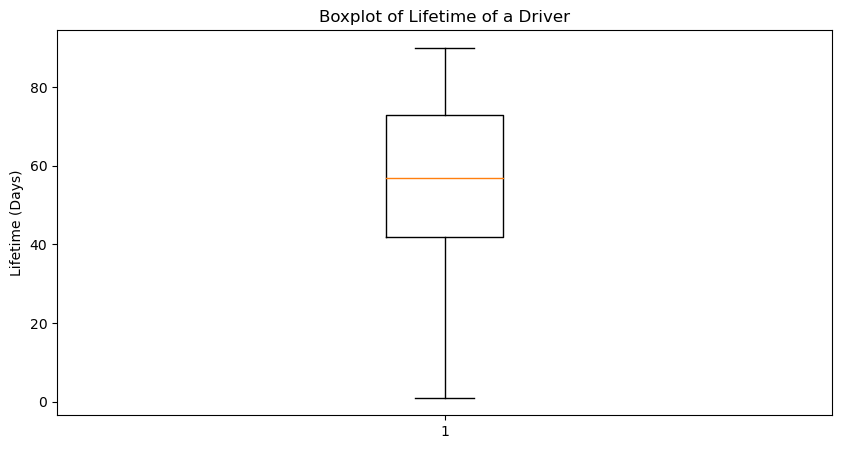

In [32]:
#Lets first take a look at spread of driver lifetime

f, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('Lifetime (Days)')
ax.set_title('Boxplot of Lifetime of a Driver')
plt.grid(False)
ax.boxplot(driver_info['driver_tenure'],showfliers = True);

In [33]:
stats.skew(driver_info['driver_tenure'],bias = True) # negative skewness, skewed left 
# because absolute value of skewness is less than .5, we can say that the data is relatively normal 

-0.482987961197601

In [34]:
stats.kurtosis(driver_info['driver_tenure']) 
#less prone to outliers as it is small

-0.5571842645119176

* The skewness tells us that the data is slightly skewed to the left, but because the absolute value of the skewness is still less than .5 we can conclude that the data is relatively normal. 
* The kurtosis value tells us that there’s a low chance for outliers, which reinforces the results we got from the boxplot.

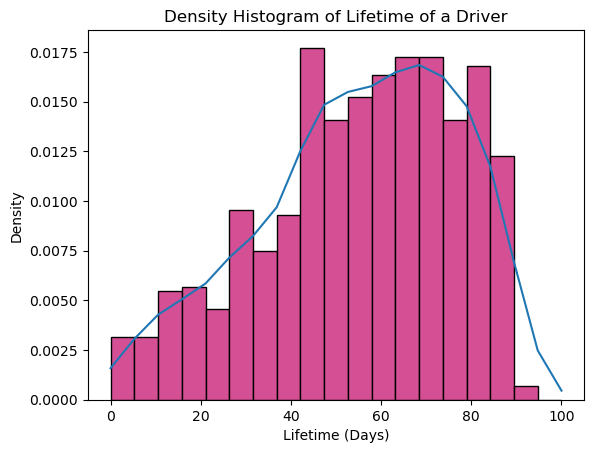

In [35]:
n, x, _ = plt.hist(driver_info['driver_tenure'],bins=np.linspace(0, 100, 20),density=True, color ='#D54F94', edgecolor='black');
density = stats.gaussian_kde(driver_info['driver_tenure'])
plt.plot(x, density(x))
plt.xlabel('Lifetime (Days)')
plt.title('Density Histogram of Lifetime of a Driver')
plt.ylabel('Density')
plt.grid(False);

In [36]:
print('Average Tenure: ',driver_info['driver_tenure'].mean())
print('Median Tenure: ',driver_info['driver_tenure'].median())

Average Tenure:  55.10513739545998
Median Tenure:  57.0


Plotting out the density histogram of lifetime confirms previous results. The lifetimes are relatively normal meaning that 
there shouldn’t be too big of a difference between the mean and median being a representation of the average lifetime. Because there is still a slight skewness though, my conclusion is that the median will most likely be a better representation of the average projected lifetime, which means that once a driver is onboarded, we can predict that they will typically continue driving for Lyft for 57 days.

### Number of Active Rides and Drivers over time (In weekly Buckets)

In [37]:
weekly_data = ride_data.groupby('ride_week').agg({
    'ride_id': 'nunique',
    'driver_id': 'nunique'
}).reset_index()

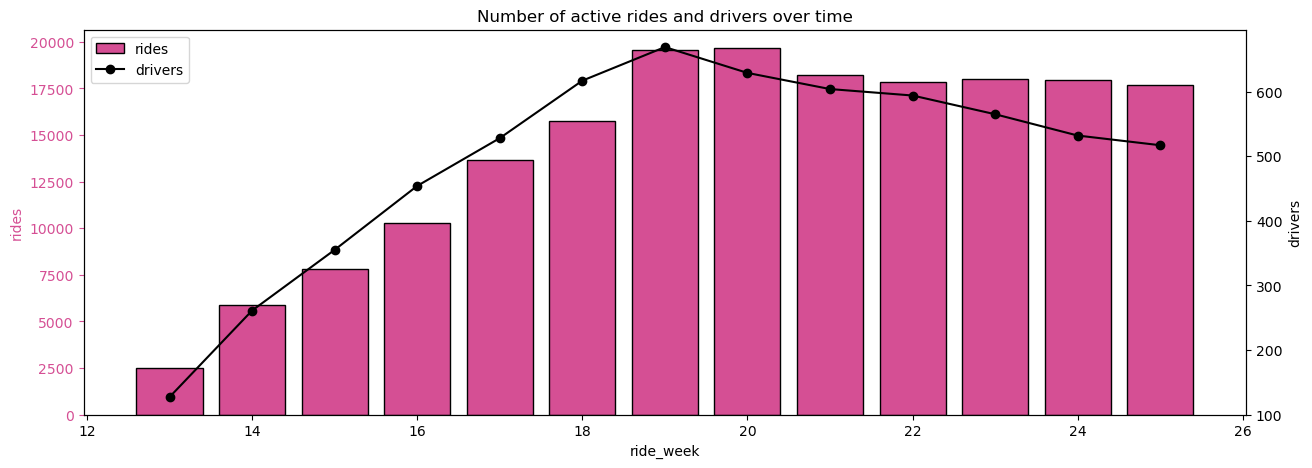

In [38]:
fig, ax1 = plt.subplots(figsize=(15, 5))

ax1.bar(weekly_data['ride_week'], weekly_data['ride_id'], color='#D54F94', label='rides', edgecolor ='black')
ax1.set_xlabel('ride_week')
ax1.set_ylabel('rides', color='#D54F94')
ax1.tick_params('y', colors='#D54F94')


ax2 = ax1.twinx()
ax2.plot(weekly_data['ride_week'], weekly_data['driver_id'], color='black', label='drivers', marker='o')
ax2.set_ylabel('drivers', color='black')
ax2.tick_params('y', colors='black')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

# Remove gridlines
ax1.grid(False)
ax2.grid(False)

plt.title('Number of active rides and drivers over time')
plt.show()


When we see weekly increase/decrease in both rides and drivers, we see that

* Lyft started with 2500 rides a week and 100 drivers which peaked between 19th and 20th week to around 20K rides and 670 active drivers.
* There is also an evident decline (more stark in number of drivers) after 20th week.

## 2. Explore how drivers churn once they start driving with Lyft.

### Are there any predictive indicators for driver churn?

* In order to see predictive indicators of driver churn, we must first analyse data to see what drivers have actually churned.
* Based on data, since last onboarding date is 15th of May, we can use data and look for recently inactive drivers. 
* We can also use the proportion of tenure of drivers they actively took rides during to see their dedication towards driving with lyft

In [39]:
last_ride_date = '2016-06-26' 

In [40]:
driver_info['driver_onboard_date'].max()

Timestamp('2016-05-15 00:00:00')

last ride day is just the maximum or latest ride date. Since 26th is Sunday and we know that a good chunk of drivers don't 
work on weekends, we should consider drivers who have been inactive for atleast 3 or more days to decide on churn

In [41]:
driver_info['days_to_last_ride'] = (pd.to_datetime(last_ride_date)) - driver_info['last_ride']
driver_info['days_to_last_ride'] = driver_info['days_to_last_ride'].astype('string').str.split().str[0]
driver_info['days_to_last_ride'] = driver_info['days_to_last_ride'].astype('int64')
driver_info.head()

,index,driver_id,total_ride_count,total_distance,active_days,total_duration,lifetime_value,lyft_profit,perday_ridecount_mean,accept_response_time_mean,...,short_ride,evening_ride,morning_ride,night_ride,prime_time_rides,driver_tenure,driver_onboard_date,onboard_week,active_day_proportion,days_to_last_ride
0,0,002be0ffdc997bd5c50703158b7c2491,277,1080.718227,56,3687.300000,3560.056648,614.985939,3.043956,8.407942,...,95,103.0,85.0,89.0,0.397112,86.0,2016-03-29,13,0.651163,3
1,1,007f0389f9c7b03ef97098422f902e62,31,72.986751,12,341.616667,321.434698,53.436940,0.340659,11.838710,...,11,24.0,6.0,1.0,0.387097,85.0,2016-03-29,13,0.141176,4
2,2,011e5c5dfc5c2c92501b8b24d47509bc,34,167.454513,12,486.750000,482.299206,84.559841,0.373626,7.294118,...,12,24.0,8.0,2.0,0.470588,68.0,2016-04-05,14,0.176471,14
3,3,0152a2f305e71d26cc964f8d4411add9,191,913.639419,40,2908.683333,2610.189071,454.793643,2.098901,14.198953,...,41,17.0,67.0,107.0,0.251309,64.0,2016-04-23,16,0.625000,0
4,4,01674381af7edd264113d4e6ed55ecda,375,1939.782924,40,5957.383333,5379.644866,944.653948,4.120879,12.528000,...,107,0.0,350.0,25.0,0.264000,56.0,2016-04-29,17,0.714286,2


* Condition #1: There has been no ride in June. 

In [42]:
driver_info['churn_indicator'] = np.where(
    (driver_info['last_ride'] < '2016-06-01') | 
    ((driver_info['last_ride'] >= '2016-06-01') & (driver_info['active_day_proportion'] < 0.05)),
    1,0)

In [43]:
driver_info[(driver_info['last_ride'] >= '2016-06-01') & (driver_info['active_day_proportion']<0.05)][['first_ride','last_ride']]

,first_ride,last_ride
438,2016-04-27,2016-06-22


In [44]:
#driver_info[(driver_info['last_ride'] > '2016-06-01') & (driver_info['active_day_proportion'] <= 0.10) 
#             & (driver_info['accept_response_time_mean'] > 11.91) & (driver_info['total_ride_count'] <10)]

### Predictive indicators of Churn

I have started by looking into correlation to see what factors here affect churn the most and then used the variables 
of highest significance in a linear regression model to assess if they can be used to make churn predictions

In [45]:
driver_info_corr = driver_info[['total_ride_count', 'total_distance', 'active_days',
       'total_duration', 'lifetime_value', 'lyft_profit',
       'perday_ridecount_mean', 'accept_response_time_mean',
       'arrival_time_mean', 'wait_time_mean', 'first_ride', 'last_ride',
       'long_ride', 'med_ride', 'short_ride', 'evening_ride', 'morning_ride',
       'night_ride','prime_time_rides', 'driver_tenure', 'driver_onboard_date', 'onboard_week',
       'days_to_last_ride', 'active_day_proportion', 'churn_indicator']]

<Axes: >

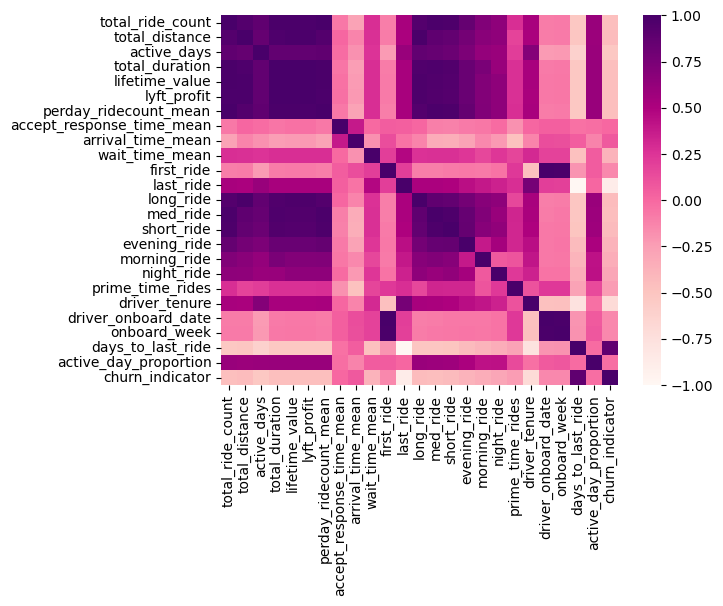

In [46]:
sns.heatmap(driver_info_corr.corr(), cmap = 'RdPu')

In [47]:
pd.DataFrame(driver_info_corr.corr()['churn_indicator']).sort_values(by= 'churn_indicator' , ascending=False).iloc[1:]

,churn_indicator
days_to_last_ride,0.878993
arrival_time_mean,0.073246
accept_response_time_mean,0.000417
active_day_proportion,-0.023942
onboard_week,-0.146339
driver_onboard_date,-0.146471
first_ride,-0.147620
prime_time_rides,-0.238601
night_ride,-0.292922
morning_ride,-0.340788


* With the feature set we have, churn seems to be highly correlated with __days_to_last_ride__ which is the difference between last ride a driver has taken and last ride date of the dataset. In production/realtime environment, this could be difference between current date and date last ride taken by a driver.
* Negatively correlated with __driver_tenure__, that is the smaller the tenure, the bigger there would be a possibility that a driver will churn, the bigger the tenure, the more there will be possibility of lyft driver staying with the company. 
* Also negative correlation with __lifetime_value__, the negative correlation indicates an inversely proportional relationship meaning the more less value a driver generates, the more chance there exists for a driver to churn. 

Correlation only helps us see the significance/effect, not really causation so in order to assess that, we can use these variables to build a logistic regression model that helps in assessing the aforementioned variables

### Testing the predictive power of the deduced variables

In [48]:
X = driver_info[['days_to_last_ride','driver_tenure','lifetime_value']]
y = driver_info[['churn_indicator']]

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [51]:
lgr = LogisticRegression()

In [52]:
lgr.fit(X_train, y_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [53]:
y_pred = lgr.predict(X_test)

In [54]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(classification_rep)

Accuracy: 1.00
Confusion Matrix:
[[205   1]
 [  0  46]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       206
           1       0.98      1.00      0.99        46

    accuracy                           1.00       252
   macro avg       0.99      1.00      0.99       252
weighted avg       1.00      1.00      1.00       252



Based on the accuracy in the confusion matrix, with these features, the model is able to predict churn accurately about 98% of the times in churn-positive cases while it indicates a 100% accuracy for cases where churn = 0. 

While the chosen features are a good representative of whether or not a driver working with Lyft will churn, there are many other factors that affect that in a realtime environment. Some of the features include:

* geographical location, 
* incentivization/ use of coupons, discount offers, 
* Driver rating,
* driver cancellation rate etc


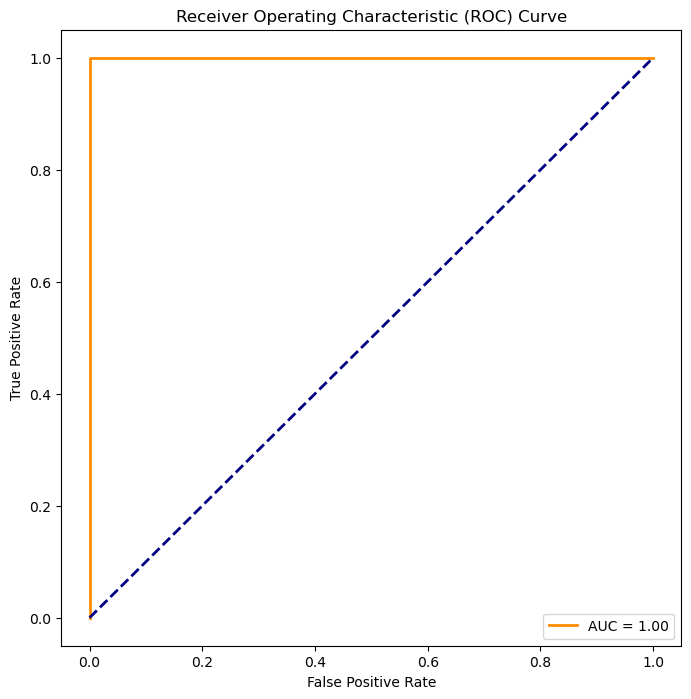

In [55]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for positive class
y_prob = lgr.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### % of Active Drivers over time (in weekly buckets, cohorted by onboard week)

In [56]:
ride_data_cohorted = pd.merge(ride_data, driver_info[['driver_id','driver_onboard_date','onboard_week']], on='driver_id')
ride_data_cohorted = ride_data_cohorted.sort_values(by = 'ride_date')

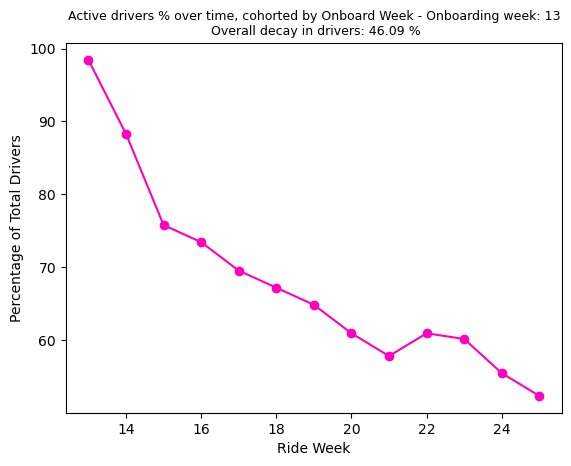

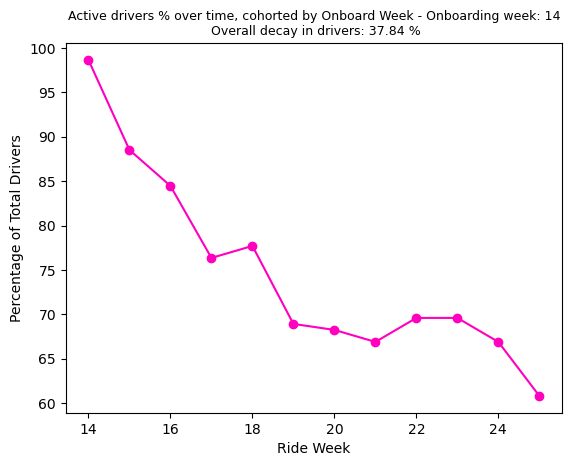

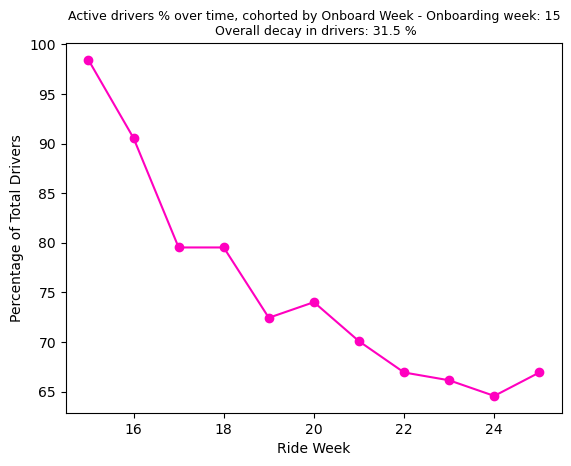

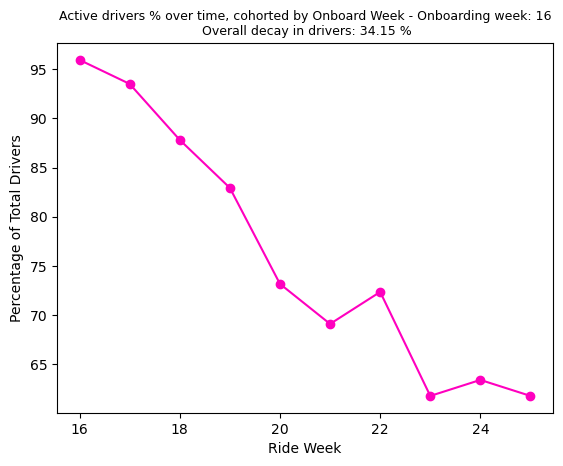

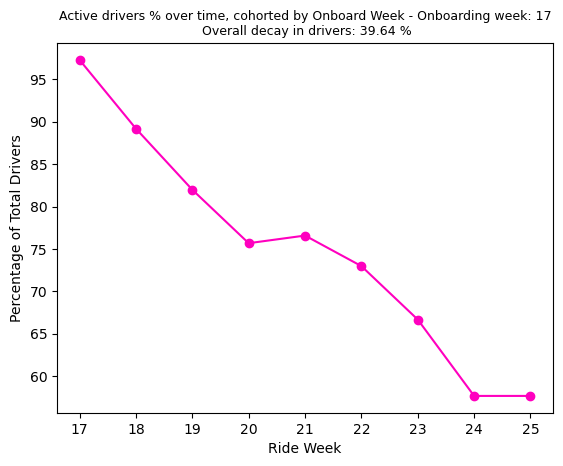

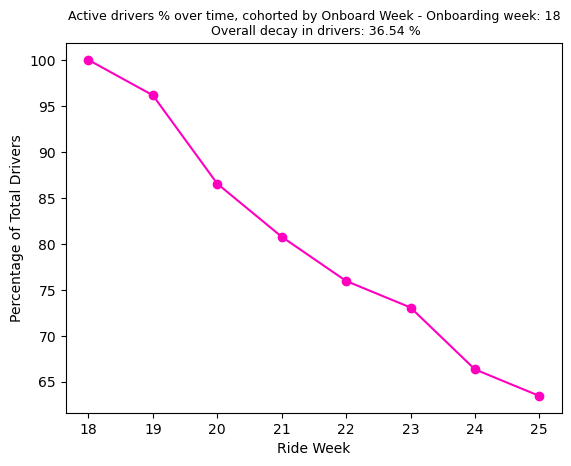

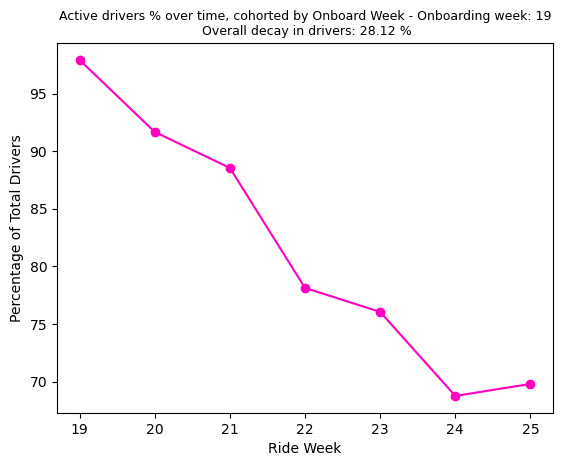

In [57]:
for week in ride_data_cohorted['onboard_week'].unique():
    cohorted_data = ride_data_cohorted[ride_data_cohorted['onboard_week']==week]
    cohorted_data_grouped = cohorted_data.groupby('ride_week').agg({'driver_id': 'nunique'}).reset_index()
    
    total_drivers_cohort = cohorted_data['driver_id'].nunique()
    
    cohorted_data_grouped['percentage_of_total'] = (cohorted_data_grouped['driver_id'] / total_drivers_cohort) * 100
    
    cohorted_data_grouped.plot(x = 'ride_week', y='percentage_of_total', legend = False,color='#FF00BF',
         marker = 'o')
    
    # Adding decay in driver count
    decay = round(100*abs(cohorted_data_grouped['driver_id'].iloc[-1] - cohorted_data_grouped['driver_id'].iloc[0])/total_drivers_cohort,2)

    
    plt.title(f'Active drivers % over time, cohorted by Onboard Week - Onboarding week: {week}\n Overall decay in drivers: {decay} %', fontsize=9)
    plt.xlabel('Ride Week')
    plt.ylabel('Percentage of Total Drivers')
    plt.grid(False)
    plt.show()
    

The most % decay that we see is for drivers onboarded in week-13 but it could also be because we have data spanning over 3 months and we have most amount of data for this set of drivers. if we remove the drivers onboarded in 1st and last onboarding week, we have an average __decay rate of 36%.__

## 3. Segment the driver population to identify driving behavior that may lead to churn 

In [58]:
driver_info.head()

,index,driver_id,total_ride_count,total_distance,active_days,total_duration,lifetime_value,lyft_profit,perday_ridecount_mean,accept_response_time_mean,...,evening_ride,morning_ride,night_ride,prime_time_rides,driver_tenure,driver_onboard_date,onboard_week,active_day_proportion,days_to_last_ride,churn_indicator
0,0,002be0ffdc997bd5c50703158b7c2491,277,1080.718227,56,3687.300000,3560.056648,614.985939,3.043956,8.407942,...,103.0,85.0,89.0,0.397112,86.0,2016-03-29,13,0.651163,3,0
1,1,007f0389f9c7b03ef97098422f902e62,31,72.986751,12,341.616667,321.434698,53.436940,0.340659,11.838710,...,24.0,6.0,1.0,0.387097,85.0,2016-03-29,13,0.141176,4,0
2,2,011e5c5dfc5c2c92501b8b24d47509bc,34,167.454513,12,486.750000,482.299206,84.559841,0.373626,7.294118,...,24.0,8.0,2.0,0.470588,68.0,2016-04-05,14,0.176471,14,0
3,3,0152a2f305e71d26cc964f8d4411add9,191,913.639419,40,2908.683333,2610.189071,454.793643,2.098901,14.198953,...,17.0,67.0,107.0,0.251309,64.0,2016-04-23,16,0.625000,0,0
4,4,01674381af7edd264113d4e6ed55ecda,375,1939.782924,40,5957.383333,5379.644866,944.653948,4.120879,12.528000,...,0.0,350.0,25.0,0.264000,56.0,2016-04-29,17,0.714286,2,0


In [59]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import warnings

#### Data Prep for clustering

In [60]:
driver_data_clustering = driver_info[['driver_id', 'total_ride_count', 'total_distance', 'active_days',
       'total_duration', 'lifetime_value', 'lyft_profit',
       'perday_ridecount_mean', 'accept_response_time_mean',
       'arrival_time_mean', 'wait_time_mean',
       'long_ride', 'med_ride', 'short_ride', 'evening_ride', 'morning_ride',
       'night_ride','prime_time_rides', 'driver_tenure', 'onboard_week',
       'days_to_last_ride', 'active_day_proportion', 'churn_indicator']]

  File "C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


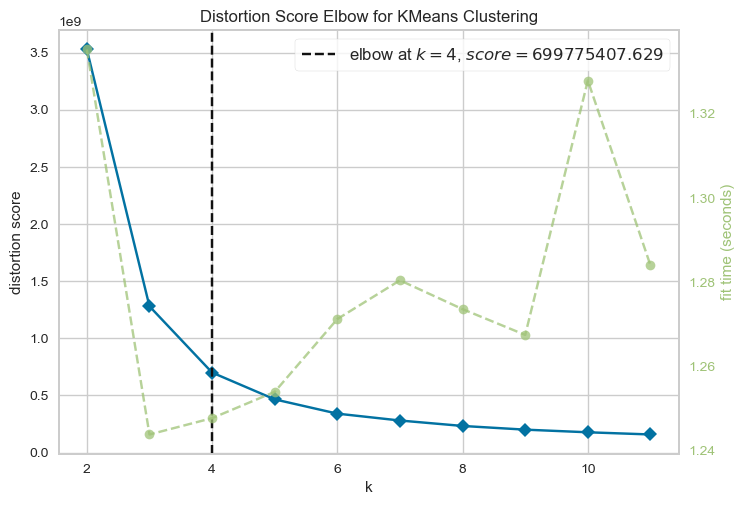

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [61]:
# Ignore all warnings
warnings.filterwarnings('ignore')

# Use the KElbowVisualizer to determine the optimal number of clusters
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(driver_data_clustering.drop(['driver_id'], axis=1))
visualizer.show()

In [62]:
# Fit a K-Means model with the optimal number of clusters
kmeans = KMeans(n_clusters=visualizer.elbow_value_, random_state=42)
kmeans.fit(driver_data_clustering.drop(['driver_id'], axis=1))

KMeans(n_clusters=4, random_state=42)

In [63]:
driver_info.columns

Index(['index', 'driver_id', 'total_ride_count', 'total_distance',
       'active_days', 'total_duration', 'lifetime_value', 'lyft_profit',
       'perday_ridecount_mean', 'accept_response_time_mean',
       'arrival_time_mean', 'wait_time_mean', 'first_ride', 'last_ride',
       'long_ride', 'med_ride', 'short_ride', 'evening_ride', 'morning_ride',
       'night_ride', 'prime_time_rides', 'driver_tenure',
       'driver_onboard_date', 'onboard_week', 'active_day_proportion',
       'days_to_last_ride', 'churn_indicator'],
      dtype='object')

In [64]:
# Adding Clusters in the form of a column in the main driver dataset
driver_info['cluster'] = kmeans.labels_

In [65]:
clustered_driver_data = driver_info.groupby('cluster').agg({
    'driver_id': 'nunique',
    'total_ride_count': 'mean',
    'total_distance':'mean',
    'active_days': 'mean',
    'lifetime_value': 'mean',
    'lyft_profit': 'mean',
    'perday_ridecount_mean': 'mean',
    'accept_response_time_mean': 'mean',
    'arrival_time_mean': 'mean',
    'wait_time_mean': 'mean',
    'long_ride': 'mean',
    'med_ride': 'mean',
    'short_ride': 'mean',
    'morning_ride':'mean',
    'evening_ride':'mean',
    'prime_time_rides':'mean',
    'night_ride':'mean',    
    'driver_tenure': 'mean',
    'onboard_week': 'mean',
    'active_day_proportion':'mean',
    'churn_indicator': 'sum'
}).reset_index()


In [66]:
clustered_driver_data['churn_ratio'] = clustered_driver_data['churn_indicator']/clustered_driver_data['driver_id']

In [67]:
clustered_driver_data

,cluster,driver_id,total_ride_count,total_distance,active_days,lifetime_value,lyft_profit,perday_ridecount_mean,accept_response_time_mean,arrival_time_mean,...,short_ride,morning_ride,evening_ride,prime_time_rides,night_ride,driver_tenure,onboard_week,active_day_proportion,churn_indicator,churn_ratio
0,0,286,255.468531,1055.760029,39.104895,3384.809344,587.332564,2.807346,11.685998,242.874221,...,85.811189,99.255245,96.447552,0.358235,59.765734,64.650350,15.737762,0.620501,7,0.024476
1,1,56,602.285714,2681.983183,60.357143,8365.080867,1461.793309,6.618524,11.409404,236.071374,...,201.071429,203.303571,237.750000,0.372021,161.232143,70.625000,15.285714,0.863069,0,0.000000
2,2,340,42.605882,208.829624,11.488235,596.881505,104.544247,0.468197,12.241863,296.117424,...,12.720588,16.247059,17.382353,0.282043,8.976471,39.597059,15.885294,0.391341,154,0.452941
3,3,155,406.000000,1750.625210,49.096774,5510.093125,959.591080,4.461538,11.781441,248.306321,...,133.354839,167.722581,156.335484,0.353652,81.941935,65.903226,15.703226,0.758176,2,0.012903


* __Cluster#1:__ This cluster has excellent drivers. With __zero churns__, these are the high acheivers in lyft business, these __56 drivers__ take more rides than others which is implied by average distance, their average tenure is __70 days__ which is collectively higher than drivers in other clusters. The drivers in this cluster work nearly __86%__ of their time after getting onboarded. They have an average response time of __11.4__, meaning the respond to ride requests faster than other drivers on average and consequently, their lifetime value as well as profit they bring to Lyft (i.e. __8365 and 1462 dollars__ respectively) is more than drivers in other clusters. The drivers in this cluster also take advantage of peak hours or prime time and have a high percentage of rides __(37%)__ being in high demand hours. 


* __Cluster#3:__ This cluster has good drivers. These __155 active drivers__ work __75%__ of their tenures. Their tenure with Lyft is __66 days__ days on average. With a churn ratio of just __1.3%__, they've on average taken around __400 rides__, generating an average lifetime value of __5510 dollars__, profiting the company on average by __1462 dollars__. These drivers have an average response time of __11.8 seconds__ which is less than average so they are quick to respond to the ride requests. Most of the rides taken by the drivers here are long. __36%__ of the rides taken by drivers in this cluster are from peak hours.

* __Cluster#0:__ In terms of Lifetime value, this is the 3rd best cluster with __286 drivers__ and a churn ratio of __2.4%.__ These drivers have on average taken __256 rides__ and generated a value of __3385 dollars, 587 dollars__ for Lyft. These drivers have an average of __65 days__ in tenure and actively work on __62%__ of their tenure days which is less in comparison to those in cluster# 1 and cluster# 3. These could be casual Lyft drivers - who dont work with Lyft full-time. __35%__ of the rides taken by drivers in this cluster are from peak/prime hours. 

* __Cluster#2:__ This is the cluster of worst drivers in the dataset. These __340__ low performig drivers (40% of the total drivers) have a very high churn rate of __~46%__. These drivers have an average tenure of __40__ days in which, they actively work only __39% of the days (12 days)__ indicating that these are mostly beginner drivers if not deliberately bad. Their mean ride count is hardly a ride per day, they also rightfully have an inflated accept response time of __12 seconds.__ Their wait time after having arrived at riders pickup location is quite small (__only 4 seconds__). It is also highly probable that these drivers have bad ratings, higher cancellation rates and/or are inexperienced drivers. Only __28%__ of the rides taken by drivers in this cluster are from peak/prime hours, looks like these drivers don't really take advantage of high demand times. 

### Conclusion:

Based on the clusters of drivers, churn seems to be highly driven by 
1. Driver Tenure
2. Active_day_proportion
3. Response time to ride requests
4. prime_time_rides

Some of the features not present in the provided dataset that could also be utilized are driver rating, cancellation rates

## 4.	What are the main factors that affect a driver’s lifetime value? Please support your answers using your data analysis. 

Lifetime Value of a Lyft driver is the value that a driver generates in $$, we have already established that it can be seen
as the total ride fare of rides a Lyft driver takes in their tenure. In order to assess what factors affect driver's lifetime value, we can use correlation:

In [68]:
driver_info_corr_LTV = driver_info[['total_ride_count','total_duration', 'lifetime_value', 
                                    'accept_response_time_mean', 'prime_time_rides','arrival_time_mean', 
                                    'wait_time_mean', 'driver_tenure', 'driver_onboard_date','evening_ride', 
                                    'morning_ride', 'night_ride','active_day_proportion']]

<Axes: >

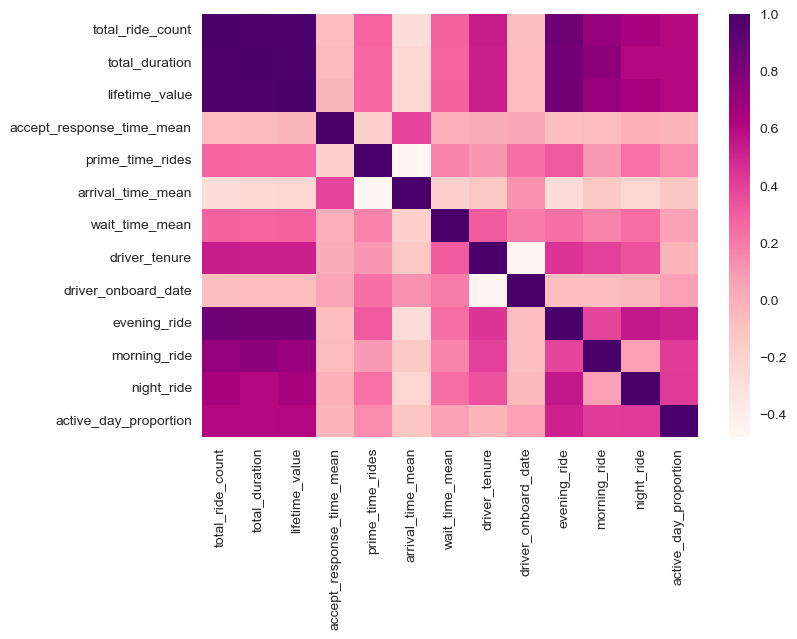

In [69]:
sns.heatmap(driver_info_corr_LTV.corr(), cmap = 'RdPu')

In [70]:
#To just assess the factors for LTV
pd.DataFrame(driver_info_corr_LTV.corr()['lifetime_value']).sort_values(by= 'lifetime_value' , ascending=False).iloc[1:]

,lifetime_value
total_duration,0.994194
total_ride_count,0.987068
evening_ride,0.833419
morning_ride,0.710679
night_ride,0.652161
active_day_proportion,0.607790
driver_tenure,0.524100
wait_time_mean,0.278239
prime_time_rides,0.270918
accept_response_time_mean,-0.040452


Lifetime value seems to be affected by:
* total duration of rides a driver spends - highly positively correlated, has a directly proportional relationship
* number of rides a driver takes - highly positively correlated, has a directly proportional relationship
* proportion of tenure a driver actively takes rides - highly positively correlated, has a directly proportional relationship
* Total Tenure of driver - positively correlated, has a directly proportional relationship
* Time of the day - evening rides seem to have a larger impact on LTV than evening and night, we can further assess if more value is producted in the morning than other times. 
* time a driver waits after reaching pickup points. - positively correlated, has a directly proportional relationship although not too impactful in terms of LTV
* Whether or not a rides are taken when the demand is higher, ofcourse it has a direct effect on LTV, positively correlated
* the time drivers take to respond to the a request - negatively correlated, has an inversely proportional relationship, low impact
* the onboard date - negatively correlated, has an inversely proportional relationship, low impact
* the time it takes after the ride is accepted, for the driver to arrive at the pickup point - negatively correlated, has an inversely proportional relationship, low impact

In [71]:
ride_data['hour'] = ride_data['requested_at'].dt.hour

In [72]:
hourwise_data = ride_data.groupby('hour').agg({
    'ride_id': 'nunique',
    'driver_id': 'nunique',
    'ride_distance': 'sum',
    'ride_duration' : 'sum',
    'ride_total_cost': 'sum',
    'lyft_profit': 'sum',
    'ride_prime_time': 'mean',
    'ride_accept_response_time':'mean',
    'ride_wait_time': 'mean',
    'ride_arrival_time':'mean'
}).reset_index()

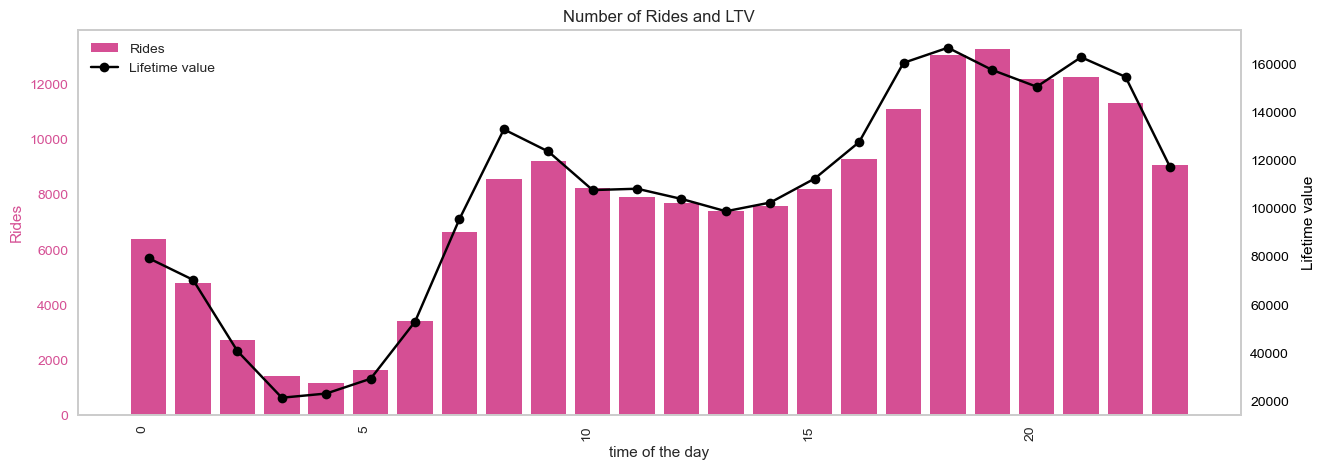

In [73]:
fig, ax1 = plt.subplots(figsize=(15, 5))

# Line plot on ax1
ax1.bar(hourwise_data['hour'], hourwise_data['ride_id'], color='#D54F94', label='Rides')
ax1.set_xlabel('time of the day')
ax1.set_ylabel('Rides', color='#D54F94')
ax1.tick_params('y', colors='#D54F94')

# Set rotation for x-axis labels
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90, ha='right')

# Create a second y-axis on the right
ax2 = ax1.twinx()
ax2.plot(hourwise_data['hour'], hourwise_data['ride_total_cost'], color='black', label='Lifetime value', marker = 'o')
ax2.set_ylabel('Lifetime value', color='black')
ax2.tick_params('y', colors='black')

# Remove gridlines
ax1.grid(False)
ax2.grid(False)

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Number of Rides and LTV')
plt.show()

We can see that we have more value generated in the evening, which proves our previously discerned effect of evening rides
on LTV

## 5.	How does the demand for rides impact on the number of drivers? 

- In order to assess demand for rides, i think it is important to assess times with high demand by day of the week, or by hour or over time generally. 
- Some other aspects through which this could also be explored is region, and how drivers are being incentivized/encouraged to take on more rides in a high-demand, and the kind of ride chosen by the rider


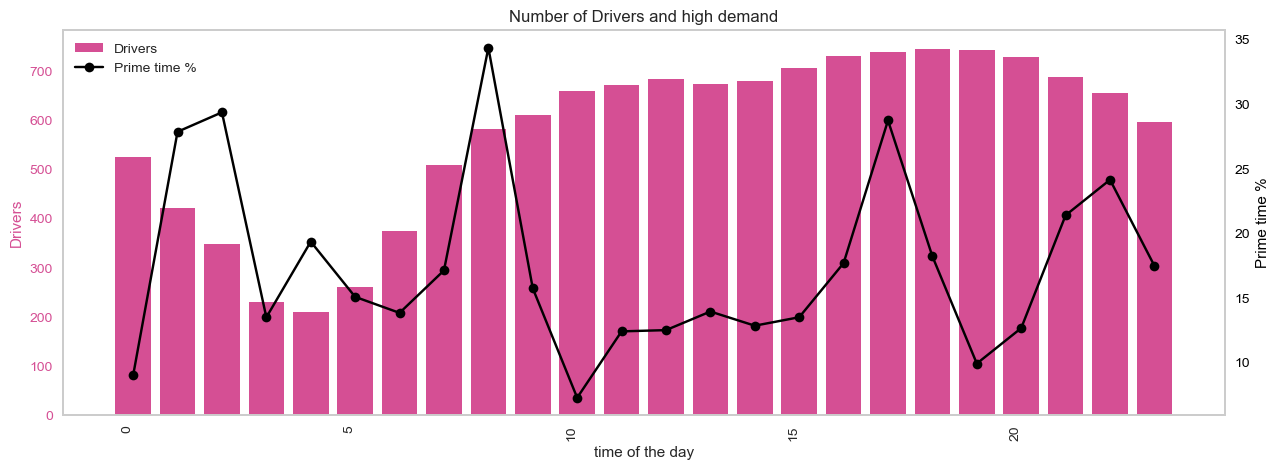

In [74]:
fig, ax1 = plt.subplots(figsize=(15, 5))

# Line plot on ax1
ax1.bar(hourwise_data['hour'], hourwise_data['driver_id'], color='#D54F94', label='Drivers')
ax1.set_xlabel('time of the day')
ax1.set_ylabel('Drivers', color='#D54F94')
ax1.tick_params('y', colors='#D54F94')

# Set rotation for x-axis labels
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90, ha='right')

# Create a second y-axis on the right
ax2 = ax1.twinx()
ax2.plot(hourwise_data['hour'], hourwise_data['ride_prime_time'], color='black', label='Prime time %', marker = 'o')
ax2.set_ylabel('Prime time %', color='black')
ax2.tick_params('y', colors='black')

# Remove gridlines
ax1.grid(False)
ax2.grid(False)

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Number of Drivers and high demand')
plt.show()

* We have already established that the supply of drivers is low during the night hours, as there are also evidently, less rides so even though the prime time % increases due to shortage of supply, there is more time-of-the-day effect there that leads to less drivers. 

* During the day however, the peak hours hour 8-9 AM and 5-6 PM, during these two times, we do see an increase in number of drivers as compared to their number in previous hours. 

In [75]:
ride_data['weekday'] = ride_data['ride_date'].dt.day_name()

In [76]:
weekday_data = ride_data.groupby('weekday').agg({
    'ride_id': 'nunique',
    'driver_id': 'nunique',
    'ride_distance': 'sum',
    'ride_duration' : 'sum',
    'ride_total_cost': 'sum',
    'lyft_profit': 'sum',
    'ride_prime_time': 'mean',
    'ride_accept_response_time':'mean',
    'ride_wait_time': 'mean',
    'ride_arrival_time':'mean'
}).reset_index()

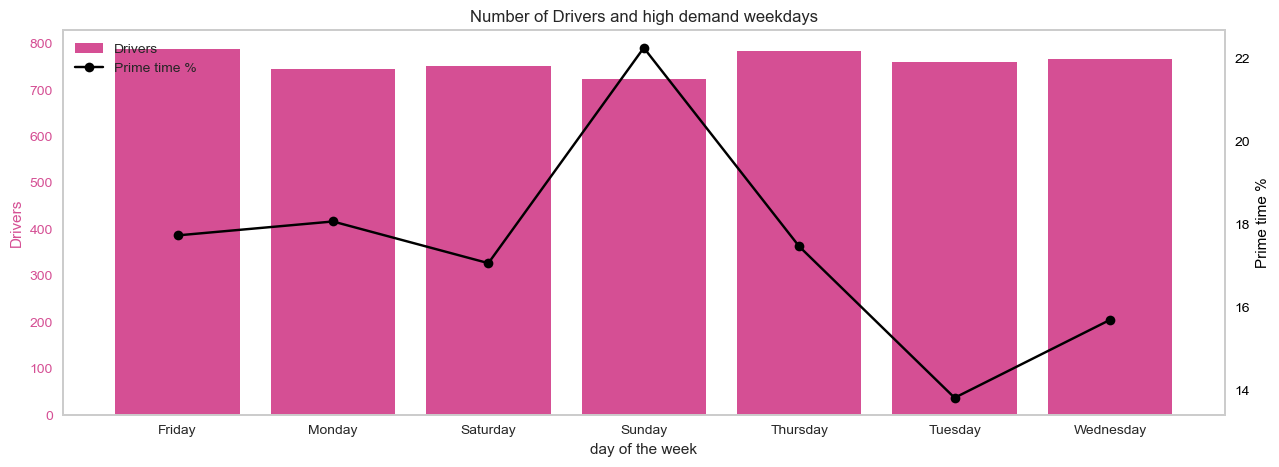

In [77]:
fig, ax1 = plt.subplots(figsize=(15, 5))

# Line plot on ax1
ax1.bar(weekday_data['weekday'], weekday_data['driver_id'], color='#D54F94', label='Drivers')
ax1.set_xlabel('day of the week')
ax1.set_ylabel('Drivers', color='#D54F94')
ax1.tick_params('y', colors='#D54F94')

# Create a second y-axis on the right
ax2 = ax1.twinx()
ax2.plot(weekday_data['weekday'], weekday_data['ride_prime_time'], color='black', label='Prime time %', marker = 'o')
ax2.set_ylabel('Prime time %', color='black')
ax2.tick_params('y', colors='black')

# Remove gridlines
ax1.grid(False)
ax2.grid(False)

# Add legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title('Number of Drivers and high demand weekdays')
plt.show()

* We do see a prime time rides % on sunday as compared to any other day but we have already established that a lot of drivers 
dont work on Sundays - this is just driven by high demand and is happening more because of day of the week than anything else.

In [78]:
pd.DataFrame(driver_info_corr.corr()['prime_time_rides']).sort_values(by= 'prime_time_rides' , ascending=False).iloc[1:]

,prime_time_rides
med_ride,0.322059
short_ride,0.318532
evening_ride,0.314608
last_ride,0.279225
total_ride_count,0.276329
perday_ridecount_mean,0.276329
lifetime_value,0.270918
lyft_profit,0.269335
total_duration,0.267610
driver_onboard_date,0.230848


- From the correlation POV, the prime time % is negatively correlated with arrival time of the driver at pickup location, this could have to do with the traffic conditions, or time of the day, or distance between the area where driver accepted the ride and the pick up point. We can say that in high demand times when drivers at higher proximity are assigned to riders, it affects the time it takes for them to pick rider up. 

- It is also positively correlated with driver lifetime value because of higher fares ofcourse. 

- High demand drives high incentives for the drivers, and there are groups of drivers that take advantage of the prime time opportunity as indicated by the segmentation analysis. 

## 6. Driver’s Lifetime Value (LTV)
Recommend a Driver’s Lifetime Value (LTV) (i.e. the value of a driver to Lyft over the entire projected lifetime of a driver). State the components of your LTV equation and the assumptions made to calculate your final LTV.



Value of a drivers lifetime is the monetary value generated by a driver over the span of his time with Lyft, or a sum of what riders pay a driver during his tenure with Lyft. Based on correlation, I have deduced the following three features to be a part of the LTV equation:

- Number of rides taken
- Total ride duration of the rides taken by a driver
- Number of days a driver actively take rides

In order to delve deeper into how much these factors affect the LTV, I decided to do a multi-variate linear regression

In [79]:
X = driver_info[['total_ride_count','total_duration','active_day_proportion']]
y = driver_info[['lifetime_value']]

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
lr = LinearRegression()

In [81]:
lr.fit(X_train, y_train)

LinearRegression()

In [82]:
y_pred = lr.predict(X_test)

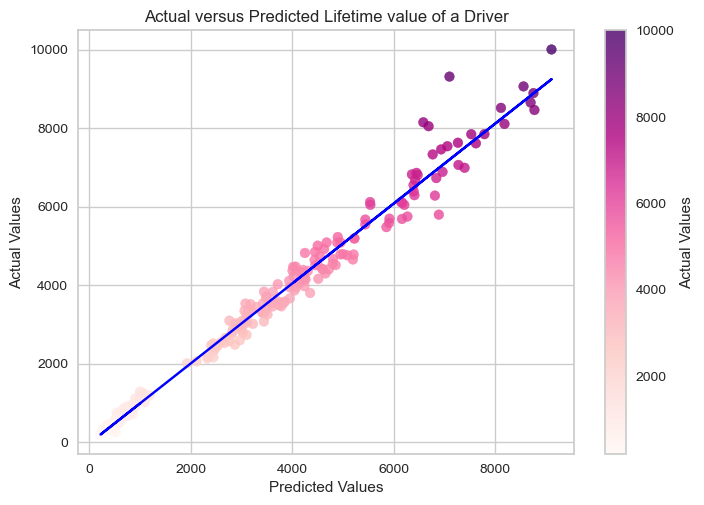

In [83]:
# Ensure y_pred and y_test are 1D arrays
y_pred = np.ravel(y_pred)
y_test = np.ravel(y_test)

# Scatter plot with colormap
norm = Normalize(vmin=min(y_test), vmax=max(y_test))
plt.scatter(x=y_pred, y=y_test, c=y_test, cmap='RdPu', norm=norm, alpha=0.8)

# Regression line
fit = np.polyfit(y_pred, y_test, 1)
line = np.poly1d(fit)
plt.plot(y_pred, line(y_pred), color='blue')

# Labels and title
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual versus Predicted Lifetime value of a Driver')

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Actual Values')

# Show the plot
plt.show()

In [84]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 90017.02814879999
R-squared: 0.9842189554546615


In [85]:
coefficients = lr.coef_[0]
intercept = lr.intercept_[0]

# Display the regression equation
equation = f'Regression Equation: LTV = {intercept:.2f} + '
for i, coef in enumerate(coefficients):
    equation += f'{coef:.2f} * {X.columns[i]} + '

# Remove the trailing '+' at the end
equation = equation[:-2]

print(equation)

Regression Equation: LTV = -18.47 + 3.18 * total_ride_count + 0.70 * total_duration + 118.27 * active_day_proportion 


In [86]:
#X_test[(X_test['driver_tenure']>50) & (X_test['driver_tenure']<58)]
X_test['predicted_ltv'] = y_pred
X_test['actual_ltv'] = y_test
X_test.head()

,total_ride_count,total_duration,active_day_proportion,predicted_ltv,actual_ltv
209,266,4435.550000,0.647059,4029.583554,4225.674823
823,323,4343.766667,0.614286,4142.289892,4045.533358
78,45,709.750000,0.303030,660.617149,812.022098
67,61,887.966667,0.500000,860.378496,955.951148
409,235,3777.883333,0.909091,3498.549201,3713.266548


Given high r-squared value of __0.98__ this model is good to use for LTV prediction.The coefficients shows that the main indicator of driver LTV active_day_proportion with an exponentially higher coefficient than the rest, then the total ride count. Small coefficient for total_duration indicates that they might not be as important. 

I did try doing a regression with just the two most important attributes with much higher co-efficient but the r-squared value went a little down to 0.96 so I decided to stick with regression using the three features four features.

In [87]:
driver_info.describe()

,index,total_ride_count,total_distance,active_days,total_duration,lifetime_value,lyft_profit,perday_ridecount_mean,accept_response_time_mean,arrival_time_mean,...,morning_ride,night_ride,prime_time_rides,driver_tenure,driver_onboard_date,onboard_week,active_day_proportion,days_to_last_ride,churn_indicator,cluster
count,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,837.000000,...,837.000000,837.000000,837.000000,837.000000,837,837.0,837.000000,837.000000,837.000000,837.000000
mean,421.140980,220.081243,949.208371,31.158901,3154.042891,2979.096950,518.660932,2.418475,11.910966,265.053080,...,85.176822,50.029869,0.327358,55.105137,2016-04-19 00:20:38.709677568,15.761051,0.569138,12.910394,0.194743,1.434886
min,0.000000,3.000000,6.144795,2.000000,28.533333,25.687087,3.868770,0.032967,5.044444,100.083333,...,0.000000,0.000000,0.000000,1.000000,2016-03-28 00:00:00,13.0,0.031250,0.000000,0.000000,0.000000
25%,212.000000,44.000000,210.527694,12.000000,639.383333,618.060833,108.623040,0.483516,9.523810,207.500000,...,15.000000,5.000000,0.250000,42.000000,2016-04-06 00:00:00,14.0,0.366667,0.000000,0.000000,0.000000
50%,421.000000,224.000000,901.312569,32.000000,3165.100000,2958.450547,513.018842,2.461538,11.064516,246.290909,...,44.000000,22.000000,0.333333,57.000000,2016-04-18 00:00:00,16.0,0.584270,2.000000,0.000000,2.000000
75%,630.000000,330.000000,1435.656366,46.000000,4801.616667,4475.228280,780.628333,3.626374,13.292419,302.529617,...,139.000000,74.000000,0.402135,73.000000,2016-04-30 00:00:00,17.0,0.765625,20.000000,0.000000,2.000000
max,843.000000,919.000000,4116.112821,81.000000,12996.616667,12347.102999,2182.938220,10.098901,41.250000,722.714286,...,515.000000,470.000000,0.753623,90.000000,2016-05-15 00:00:00,19.0,2.000000,88.000000,1.000000,3.000000
std,242.965317,178.179693,782.417423,19.201147,2566.816739,2416.292784,421.661989,1.958019,4.157180,84.384440,...,92.089590,64.935745,0.116589,21.726518,NaN,1.960803,0.266453,19.540361,0.396240,1.140648


## 7.	What actionable recommendations are there for the business

- Retaining good and excellent drivers: Focusing on driver LTV and the value good drivers bring to Lyft, the business should focus on retaining and wherever possible incentivizing the drivers. Simultaneously, the business should also put some effort and time into improving the performance of average drivers and encourage them with trainings and incentivization to take more rides, stay longer with the business with an aim to convert them into good/excellent drivers along the way. 

- Identify and address issues faced by drivers and riders in marketplace: The business should identify and address the issues faced by the bad drivers, like low earnings, low ride frequency, and low ride duration, to improve their performance. Simultaneously, the business should also identify and address customer related issues from the ratings and feedback given at the end of the ride to the drivers. 

- Use real-time models to guide drivers: The business could use a heatmap that drivers can use to be in the in-demand areas nearby for building higher incentives.

- Assess the estimation methods in place and use high-impact features to come up with estimates like time of arrival, time of reaching, etc with lower variance. Modeling could also be used to identify optimal ride routes. 

- Use geographical and demographic data to assess performance and work on incentivization of customers (discount campaigns) as well as drivers based on scarcity of customers/drivers. 

- Use competitor data (whatever's accessible) in order to compare performance and practices to understand areas of improvement and opportunity within the business model

- Assess the KPIs of interest like driver response times, wait-time for a potential rider before ride is matched, ETA for driver to arrive at pickup, ratings per sub-market, analyze variance and come up with better estimates. 

- Assess performance by submarket (region), ride type, platform to come up with submarket specific approaches for improvement and expansion. 

In [88]:
driver_info.sort_values(by = 'driver_tenure')

,index,driver_id,total_ride_count,total_distance,active_days,total_duration,lifetime_value,lyft_profit,perday_ridecount_mean,accept_response_time_mean,...,morning_ride,night_ride,prime_time_rides,driver_tenure,driver_onboard_date,onboard_week,active_day_proportion,days_to_last_ride,churn_indicator,cluster
350,353,68b546b2f4102641d6774c1ce4f57457,22,74.259180,2,333.933333,255.404542,43.380908,0.241758,10.636364,...,7.0,2.0,0.227273,1.0,2016-03-30,13,2.000000,87,1,2
373,376,6eb2e0f41fc9f1fbb70e7751035fdf87,35,145.366785,2,513.800000,421.712971,72.092594,0.384615,8.400000,...,22.0,0.0,0.142857,1.0,2016-03-29,13,2.000000,88,1,2
636,639,bd057e02f75c92917389d90bb215fe91,27,75.449016,2,305.883333,258.593332,42.075809,0.296703,10.037037,...,18.0,0.0,0.037037,1.0,2016-03-29,13,2.000000,88,1,2
550,553,a2334fdb829cf96fbae920df0cce1587,25,75.868191,3,340.233333,290.443451,49.338690,0.274725,5.880000,...,8.0,13.0,0.480000,2.0,2016-04-08,14,1.500000,77,1,2
762,767,e4f3a9d5cf57b9b518136afd9757f76d,32,71.539200,4,350.683333,285.239087,45.847817,0.351648,7.062500,...,7.0,4.0,0.093750,3.0,2016-03-28,13,1.333333,87,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,510,956942174fc793c4bfb6fffc4b3c1c7b,213,851.589720,38,2575.600000,2445.878634,414.410932,2.340659,10.192488,...,17.0,16.0,0.145540,89.0,2016-03-28,13,0.426966,1,0,0
654,657,c1d662bc81ade6c9a1ec161b3076b27e,515,1804.999221,52,6959.033333,6370.543806,1093.668236,5.659341,8.244660,...,194.0,111.0,0.392233,89.0,2016-03-29,13,0.584270,0,0,3
486,489,8dbfef11a650dd9658ca0c6f70b84f88,245,840.121713,36,3178.100000,3070.447538,528.123269,2.692308,7.657143,...,9.0,59.0,0.559184,90.0,2016-03-29,13,0.400000,0,0,0
401,404,75ff47d4ba4bd4480629671a666500ba,393,1617.806223,58,5464.300000,4988.080238,860.025643,4.318681,10.882952,...,128.0,58.0,0.295165,90.0,2016-03-28,13,0.644444,0,0,3


In [89]:
tenure_count = pd.DataFrame(driver_info.groupby('active_days')['driver_id'].nunique()).reset_index(0)

In [90]:
tenure_count

,active_days,driver_id
0,2,4
1,3,3
2,4,10
3,5,19
4,6,23
...,...,...
73,76,3
74,78,1
75,79,2
76,80,1


In [91]:
bin_edges = pd.cut(tenure_count['active_days'], bins=10)


In [92]:
tenure_count['active_days_bucket'] = pd.cut(tenure_count['active_days'], bins=10)


tenure_count

In [94]:
100*tenure_count.groupby('active_days_bucket')['driver_id'].sum()/tenure_count['driver_id'].sum()

active_days_bucket
(1.921, 9.9]    17.562724
(9.9, 17.8]     17.801673
(17.8, 25.7]     6.093190
(25.7, 33.6]    10.274791
(33.6, 41.5]    15.890084
(41.5, 49.4]    13.022700
(49.4, 57.3]    10.035842
(57.3, 65.2]     5.854241
(65.2, 73.1]     2.150538
(73.1, 81.0]     1.314217
Name: driver_id, dtype: float64

* 35.4 % of the drivers are active <= 18 days in their tenure. 
* 49% of the drivers are active 26 - 57 days in their tenure. 
